# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 28.01.2022

Мягкий дедлайн: 23:59MSK 14.02.2022

Жесткий дедлайн: 23:59MSK 17.02.2022

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [ ]:
import numpy as np
rng = np.random.default_rng(2022)
rng

Generator(PCG64) at 0x7F8F88066950

In [ ]:
import keras
from keras.datasets import fashion_mnist

(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(x_train_pics.shape[0], -1)
x_test = x_test_pics.reshape(x_test_pics.shape[0], -1)

#__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

### Тесты без пайплайна (не надо проверять)

In [ ]:
xi = x_train[np.random.randint(x_train.shape[0], size=1000000)]
xj = x_train[np.random.randint(x_train.shape[0], size=1000000)]

sigma_male = np.median(np.sum((xi - xj)**2, axis=1))
sigma_male

54397.0

In [ ]:
###DO NOT SCALE 
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)

In [ ]:
w_samples = np.random.normal(0, 1/sigma_male, (100, x_train.shape[1]))
b = np.random.uniform(-np.pi, np.pi, 100)

phi_x_train = np.cos(x_train @ w_samples.T + b)
phi_x_test = np.cos(x_test @ w_samples.T + b)

In [ ]:
phi_x_test.shape

(10000, 100)

**Без PCA**

In [ ]:
from sklearn.svm import SVC, LinearSVC

svc = SVC(kernel='linear', probability=True)
svc.fit(phi_x_train[:5000], y_train[:5000])

y1_pred = svc.predict(phi_x_test)
(y1_pred == y_test).mean()

0.7421

In [ ]:
from sklearn.svm import SVC, LinearSVC

lin_svc = LinearSVC(max_iter=3000)
lin_svc.fit(phi_x_train[:5000], y_train[:5000])

y2_pred = lin_svc.predict(phi_x_test)
(y2_pred == y_test).mean()

0.7651

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='saga', max_iter=1000)
logreg.fit(phi_x_train[:5000], y_train[:5000])

y3_pred = logreg.predict(phi_x_test)
(y3_pred == y_test).mean()

0.7263

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='saga', max_iter=100)
logreg.fit(phi_x_train[:5000], y_train[:5000])

y3_pred = logreg.predict(phi_x_test)
(y3_pred == y_test).mean()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


0.7261

**Используя PCA**

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
pca_train = pca.fit_transform(x_train)
pca_test = pca.transform(x_test)

w_samples = np.random.normal(0, 1/sigma_male, (100, pca_train.shape[1]))
b = np.random.uniform(-np.pi, np.pi, 100)

phi_x_train = np.cos(pca_train @ w_samples.T + b)
phi_x_test = np.cos(pca_test @ w_samples.T + b)

In [ ]:
from sklearn.svm import SVC, LinearSVC

svc = SVC(kernel='linear', probability=True)
svc.fit(phi_x_train[:5000], y_train[:5000])

ysample_pred = svc.predict(phi_x_test)
(ysample_pred == y_test).mean()

0.7458

In [ ]:
from sklearn.svm import SVC, LinearSVC

lin_svc = LinearSVC(max_iter=3000)
lin_svc.fit(phi_x_train[:5000], y_train[:5000])

ysample_pred = lin_svc.predict(phi_x_test)
(ysample_pred == y_test).mean()

0.7741

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='saga', max_iter=1000)
logreg.fit(phi_x_train[:5000], y_train[:5000])

ysample_pred = logreg.predict(phi_x_test)
(ysample_pred == y_test).mean()

0.7316

### Финальная модель с пайплайном

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, use_scaler=False, classifier='logreg'):
        """
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
          n_features, int: amount of synthetic random features generated with RFF approximation.
          new_dim, int: PCA output size.
          use_PCA, bool: whether to include PCA preprocessing.
          classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.use_scaler = use_scaler
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Sigma squared Male Rule estimation
        mask = np.random.randint(X.shape[0], size=(2, 1000000))
        xi, xj = X[mask[0]], X[mask[1]]
        sigma_sq = np.median(np.sum(((xi - xj) ** 2), axis=1))
        
        # Scaling and PCA
        # scaler = StandardScaler()
        # X = scaler.fit_transform(X)
        if self.use_PCA:
            self.pca = PCA(n_components=self.new_dim)
            X = self.pca.fit_transform(X)

        # Generating features with RFF
        self.w_samples = np.random.normal(0, 1/sigma_sq, (self.n_features, X.shape[1]))
        self.b = np.random.uniform(-np.pi, np.pi, self.n_features)
        Phi_X = np.cos(X @ self.w_samples.T + self.b)
        
        # Scaling new features and fit
        if self.use_scaler:
            self.scaler = StandardScaler()
            Phi_X = self.scaler.fit_transform(Phi_X)
            
        if self.classifier == 'svm':
            self.svc = SVC(kernel='linear', probability=False)
            self.svc.fit(Phi_X, y)
            
        if self.classifier == 'logreg':
            self.logreg = LogisticRegression(solver='saga')
            self.logreg.fit(Phi_X, y)
            
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        # Scaling and PCA
        # scaler = StandardScaler()
        # X = scaler.fit_transform(X)
        if self.use_PCA:
            X = self.pca.transform(X)
        
        # Generating features with RFF
        Phi_X = np.cos(X @ self.w_samples.T + self.b)
        
        # Probabilities
        if self.classifier == 'svm':
            return self.svc.predict_proba(Phi_X)
            
        if self.classifier == 'logreg':
            return self.logreg.predict_proba(Phi_X)
                
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        # Scaling and PCA
        # scaler = StandardScaler()
        # X = scaler.fit_transform(X)
        if self.use_PCA:
            X = self.pca.transform(X)
            
        # Generating features with RFF
        Phi_X = np.cos(X @ self.w_samples.T + self.b)
        
        # Classification
        if self.classifier == 'svm':
            return self.svc.predict(Phi_X)
            
        if self.classifier == 'logreg':
            return self.logreg.predict(Phi_X)
            

In [ ]:
model = RFFPipeline(n_features=1000, new_dim=50, use_PCA=False, classifier='svm')
model.fit(x_train[:5000], y_train[:5000])

y_pred = model.predict(x_test)
np.mean(y_pred == y_test)

0.8171

In [ ]:
model = RFFPipeline(n_features=1000, new_dim=50, use_PCA=True, classifier='svm')
model.fit(x_train[:5000], y_train[:5000])

y_pred = model.predict(x_test)
np.mean(y_pred == y_test)

0.8039

На подвыборке лучше себя показала модель без PCA. Поэтому для финальной прогонки используем именно её.

In [ ]:
np.random.seed(2022)
model = RFFPipeline(n_features=1000, new_dim=50, use_PCA=False, classifier='svm')
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
np.mean(y_pred == y_test)

0.8498

Обучение на всей выборке заняло 23 минуты.

#__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [29]:
from sklearn.svm import LinearSVC, SVC
from xgboost.sklearn import XGBClassifier
import time
import warnings
# warnings.filterwarnings("ignore")

In [ ]:
np.random.seed(2022)
start_time = time.time()

lin_svc = LinearSVC(max_iter=3000)
lin_svc.fit(x_train[:5000], y_train[:5000])

y_pred = lin_svc.predict(x_test)
print(f"LinearSVM accuracy: {np.mean(y_pred == y_test)}")
print(f"--- {time.time() - start_time} seconds ---")

LinearSVM accuracy: 0.7332
--- 22.760557413101196 seconds ---


In [ ]:
start_time = time.time()
kernel_svc = SVC(kernel='linear')
kernel_svc.fit(x_train[:5000], y_train[:5000])

y_pred = kernel_svc.predict(x_test)
print(f"KernelSVM accuracy: {np.mean(y_pred == y_test)}")
print(f"--- {time.time() - start_time} seconds ---")

KernelSVM accuracy: 0.7976
--- 13.547722339630127 seconds ---


In [ ]:
start_time = time.time()
kernel_svc = SVC(kernel='rbf')
kernel_svc.fit(x_train[:5000], y_train[:5000])

y_pred = kernel_svc.predict(x_test)
print(f"KernelSVM accuracy: {np.mean(y_pred == y_test)}")
print(f"--- {time.time() - start_time} seconds ---")

KernelSVM accuracy: 0.8343
--- 24.421908617019653 seconds ---


Как можно видеть линейный SVM уступает ядровому методу при одинаковом времени обучения. Это как раз связано с тем, что гауссовское ядро, которое используется в ядровом SVM позволяет использовать признаки из бесконечномерного пространства, где они могут быть линейно разделимыми. Тогда как линейный метод использует исходные признаки. 

Комментарий насчет разницы между LinearSVC() и SVC(kernel='linear'). LinearSVC это более гибкий класс для обучения линейных классификаторов, так как он использует библиотеку liblinear, который позволяет настраивать регуляризацию и лоссы. 
SVC(kernel='linear') использует библиотекку libsvm, поэтому на больших данных LinearSVC обучается быстрее. \\
https://stackoverflow.com/questions/11508788/whats-the-difference-between-libsvm-and-liblinear

In [ ]:
start_time = time.time()
xgb = XGBClassifier()
xgb.fit(x_train[:5000], y_train[:5000])

y_pred = xgb.predict(x_test)
print(f"XGBoost accuracy: {np.mean(y_pred == y_test)}")
print(f"--- {time.time() - start_time} seconds ---")

XGBoost accuracy: 0.8349
--- 114.93435788154602 seconds ---


Подберем параметры бустинга:

In [ ]:
for m_depth in [2, 3]:
  for n_est in [50,100, 200]:
    start_time = time.time()
    xgb = XGBClassifier(max_depth=m_depth, n_estimators=n_est)
    xgb.fit(x_train[:5000], y_train[:5000])

    y_pred = xgb.predict(x_test)
    print(f"Tuned XGB accuracy: {np.mean(y_pred == y_test)}, params: {m_depth}, {n_est}")
    print(f"--- {time.time() - start_time} seconds ---")

Tuned XGB accuracy: 0.8009, params: 2, 50
--- 40.6189444065094 seconds ---
Tuned XGB accuracy: 0.8224, params: 2, 100
--- 73.7978003025055 seconds ---
Tuned XGB accuracy: 0.8371, params: 2, 200
--- 145.689377784729 seconds ---
Tuned XGB accuracy: 0.8202, params: 3, 50
--- 54.45456504821777 seconds ---
Tuned XGB accuracy: 0.8349, params: 3, 100
--- 107.29931879043579 seconds ---
Tuned XGB accuracy: 0.8463, params: 3, 200
--- 222.4045352935791 seconds ---


Даже без подбора гиперпараметров XGBoost выдает результат, сопоставимый с результатом ядрового SVM. Однако потраченное на обучение время у бустинга в 4 раза больше, чем у SVM. Если же еще брать в расчет подбор параметров, то бустинг самый долгий, однако за это время качество у модели действительно повысится чуть меньше, чем на процент.

**Используя PCA:**

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
pc_train = pca.fit_transform(x_train)
pc_test = pca.transform(x_test)

In [ ]:
np.random.seed(2022)
start_time = time.time()

lin_svc = LinearSVC(max_iter=3000)
lin_svc.fit(pc_train[:5000], y_train[:5000])

y_pred = lin_svc.predict(pc_test)
print(f"LinearSVM accuracy: {np.mean(y_pred == y_test)}")
print(f"--- {time.time() - start_time} seconds ---")

LinearSVM accuracy: 0.6094
--- 30.227136611938477 seconds ---


In [ ]:
start_time = time.time()
kernel_svc = SVC(kernel='rbf')
kernel_svc.fit(pc_train, y_train)

y_pred = kernel_svc.predict(pc_test)
print(f"KernelSVM accuracy: {np.mean(y_pred == y_test)}")
print(f"--- {time.time() - start_time} seconds ---")

KernelSVM accuracy: 0.8747
--- 105.41046977043152 seconds ---


In [ ]:
start_time = time.time()
xgb = XGBClassifier(max_depth=3, n_estimators=200)
xgb.fit(pc_train[:5000], y_train[:5000])

y_pred = xgb.predict(pc_test)
print(f"XGBoost accuracy: {np.mean(y_pred == y_test)}")
print(f"--- {time.time() - start_time} seconds ---")

XGBoost accuracy: 0.8181
--- 34.72909140586853 seconds ---


Выделение главных компонент существенно ускоряет ядровой SVM, да так, что даже можно обучиться на всем датасете чуть больше, чем за минуту (23 минуты без PCA!). Причем accuracy в таком случае вырастет существенно, аж до 0.87. \\
XGBoost выдает похожее качсетво, но за большее время, поэтому осмысленно использовать именно ядровой метод, который быстрее. Не исключено, что бустинг на всем датасете при праивльно подобранных параметрах выдаст что-то большее, однако это опять же займет очень много времени.

# __Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? \\
Помогает, как мы выяснили в предыдущем пункте, понижение размерности значительно ускоряет PCA, так как признаков становится меньше (50 вместо 784), а информация о данных сохраняется наибольшая (PCA отбирает 50 самых информативных признаков по дисперсии). Отсюда, обучение проходит в несколько раз быстрее, 1.5 минуты против 23 минут без PCA.

2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features? \\
При росте n_features качество растет и выходит на плато примерно на 1000-1500 признаках. Чем больше признаков, тем больше нелинейных закономерностей улавливает модель, используя ядро, поэтому качество растет.

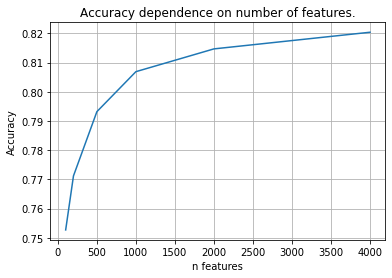

In [25]:
import matplotlib.pyplot as plt
accuracies = []

for n_features in [100, 200, 500, 1000, 2000, 4000]:
  model = RFFPipeline(n_features=n_features, new_dim=50, use_PCA=True, classifier='svm')
  model.fit(x_train[:5000], y_train[:5000])

  y_pred = model.predict(x_test)
  accuracies.append(np.mean(y_pred == y_test))

plt.plot([100, 200, 500, 1000, 2000, 4000], accuracies)
plt.title('Аccuracy dependence on number of features.')
plt.xlabel('n features')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

3. Важно ли, какую модель обучать — логистическую регрессию или SVM? \\
Незначительно, но все же SVM предпочтительнее использовать, чем Logreg для ядерной аппроксимации. SVM показывает лучшее качество и не уступает логрегу по времени.

In [32]:
start_time = time.time()
model = RFFPipeline(n_features=1000, new_dim=50, use_PCA=True, classifier='logreg')
model.fit(x_train[:5000], y_train[:5000])

y_pred = model.predict(x_test)
print(f"Logreg accuracy: {np.mean(y_pred == y_test)}")
print(f"--- {time.time() - start_time} seconds ---")

Logreg accuracy: 0.7777
--- 33.91533327102661 seconds ---


In [33]:
start_time = time.time()
model = RFFPipeline(n_features=1000, new_dim=50, use_PCA=True, classifier='svm')
model.fit(x_train[:5000], y_train[:5000])

y_pred = model.predict(x_test)
print(f"SVM accuracy: {np.mean(y_pred == y_test)}")
print(f"--- {time.time() - start_time} seconds ---")

SVM accuracy: 0.8063
--- 27.41907238960266 seconds ---


### Бонус

# __Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪

# __Задание 5. (Максимум 2 балла)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

Добавим несколько функций для генерации новых признаков в наш класс и поочередно протеситурем их на подвыборке.

In [63]:
class CoolerPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=False, func='rff', classifier='logreg'):
        """
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
          n_features, int: amount of synthetic random features generated with RFF approximation.
          new_dim, int: PCA output size.
          use_PCA, bool: whether to include PCA preprocessing.
          classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        self.func = func
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Sigma squared Male Rule estimation
        mask = np.random.randint(X.shape[0], size=(2, 1000000))
        xi, xj = X[mask[0]], X[mask[1]]
        sigma_sq = np.median(np.sum(((xi - xj) ** 2), axis=1))
        
        # Scaling and PCA
        if self.use_PCA:
            self.pca = PCA(n_components=self.new_dim)
            X = self.pca.fit_transform(X)

        # Generating features
        if self.func == 'rff':
          self.w_samples = np.random.normal(0, 1/sigma_sq, (self.n_features, X.shape[1]))
          self.b = np.random.uniform(-np.pi, np.pi, self.n_features)
          Phi_X = np.cos(X @ self.w_samples.T + self.b)

        elif self.func == 'arctan':
          self.w_samples = np.random.normal(0, 1/sigma_sq, (self.n_features, X.shape[1]))
          self.b = np.random.uniform(-np.pi, np.pi, self.n_features)
          Phi_X = np.arctan(X @ self.w_samples.T + self.b)
        
        elif self.func == 'sinh':
          self.w_samples = np.random.normal(0, 1/sigma_sq, (self.n_features, X.shape[1]))
          self.b = np.random.uniform(-np.pi, np.pi, self.n_features)
          Phi_X = np.sinh(X @ self.w_samples.T + self.b)

        elif self.func == 'indic':
          self.w_samples = np.random.normal(0, 1/sigma_sq, (self.n_features, X.shape[1]))
          self.b = np.random.uniform(-np.pi, np.pi, self.n_features)
          Phi_X = (np.cos(X @ self.w_samples.T + self.b) > 0)

        elif self.func == 'sigmoid':
          self.w_samples = np.random.normal(0, 1/sigma_sq, (self.n_features, X.shape[1]))
          self.b = np.random.uniform(-np.pi, np.pi, self.n_features)
          Phi_X = 1 / (1 + np.exp(- X @ self.w_samples.T + self.b))
        
        elif self.func == 'relu':
          self.w_samples = np.random.normal(0, 1/sigma_sq, (self.n_features, X.shape[1]))
          self.b = np.random.uniform(-np.pi, np.pi, self.n_features)
          Phi_X = ((X @ self.w_samples.T + self.b) > 0) * (X @ self.w_samples.T + self.b)

        elif self.func == 'student':
          self.w_samples = np.random.standard_t(df=1, size=(self.n_features, X.shape[1]))/sigma_sq
          self.b = np.random.uniform(-np.pi, np.pi, self.n_features)
          Phi_X = np.cos(X @ self.w_samples.T + self.b)
      
        # Fit
        if self.classifier == 'svm':
            self.svc = SVC(kernel='linear', probability=True)
            self.svc.fit(Phi_X, y)
            
        elif self.classifier == 'logreg':
            self.logreg = LogisticRegression(solver='saga')
            self.logreg.fit(Phi_X, y)
            
        return self

    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        if self.use_PCA:
            X = self.pca.transform(X)  # PCA
        
        if self.func == 'rff':
          Phi_X = np.cos(X @ self.w_samples.T + self.b)  # RFF

        elif self.func == 'arctan':
          Phi_X = np.arctan(X @ self.w_samples.T + self.b)  # Arctan

        elif self.func == 'sinh':
          Phi_X = np.sinh(X @ self.w_samples.T + self.b)  # Sinh
          
        elif self.func == 'indic':
          Phi_X = (np.cos(X @ self.w_samples.T + self.b) > 0)  # Indicator
        
        elif self.func == 'sigmoid':
          Phi_X = 1 / (1 + np.exp(- X @ self.w_samples.T + self.b))  # Sigmoid

        elif self.func == 'relu':
          Phi_X = ((X @ self.w_samples.T + self.b) > 0) * (X @ self.w_samples.T + self.b)  # RELU

        if self.func == 'student':
          Phi_X = np.cos(X @ self.w_samples.T + self.b)  # Student

        if self.classifier == 'svm':
            return self.svc.predict(Phi_X)
            
        if self.classifier == 'logreg':
            return self.logreg.predict(Phi_X)

In [ ]:
np.random.seed(2022)
model = CoolerPipeline(n_features=1000, func='rff', classifier='svm')
model.fit(x_train[:5000], y_train[:5000])

y_pred = model.predict(x_test)
print(f"RFF accuracy: {np.mean(y_pred == y_test)}")

0.8143

In [39]:
model = CoolerPipeline(n_features=1000, func='arctan', classifier='svm')
model.fit(x_train[:5000], y_train[:5000])

y_pred = model.predict(x_test)
print(f"Arctan accuracy: {np.mean(y_pred == y_test)}")

Arctanh accuracy: 0.8044


In [ ]:
model = CoolerPipeline(n_features=1000, func='sinh', classifier='svm')
model.fit(x_train[:5000], y_train[:5000])

y_pred = model.predict(x_test)
print(f"SinH accuracy: {np.mean(y_pred == y_test)}")

SinH accuracy: 0.8111


In [ ]:
model = CoolerPipeline(n_features=1000, func='indic', classifier='svm')
model.fit(x_train[:5000], y_train[:5000])

y_pred = model.predict(x_test)
print(f"Indicator accuracy: {np.mean(y_pred == y_test)}")

Indicator accuracy: 0.6665


In [42]:
model = CoolerPipeline(n_features=1000, func='sigmoid', classifier='svm')
model.fit(x_train[:5000], y_train[:5000])

y_pred = model.predict(x_test)
print(f"Sigmoid accuracy: {np.mean(y_pred == y_test)}")

Sigmoid accuracy: 0.5568


In [58]:
model = CoolerPipeline(n_features=1000, func='relu', classifier='svm')
model.fit(x_train[:5000], y_train[:5000])

y_pred = model.predict(x_test)
print(f"RELU accuracy: {np.mean(y_pred == y_test)}")

RELU accuracy: 0.8165


In [64]:
model = CoolerPipeline(n_features=1000, func='student', classifier='svm')
model.fit(x_train[:5000], y_train[:5000])

y_pred = model.predict(x_test)
print(f"Student accuracy: {np.mean(y_pred == y_test)}")

Student accuracy: 0.8033


В экспериментах я использовал арктангенс и гиперболический синус, которые показали качество сравнимые с RFF. Связано это наверное с тем, что обе эти функции монотонно возрастают на всех вещественной оси, не превнося какие-то радикальные изменения в признаки. \\
После этого я попробовал разные функции активации из нейронных сетей, которые могут как-то преобразовать признаки. \\
https://mlfromscratch.com/activation-functions-explained/#/ \\
Первой я попробовал step function, то есть индикатор от косинуса, однако качество сильно понизилось до 0.67. \\
Второй была сигмоида, качество упало еще ниже до 0.56. \\
И третьей я протестировал RELU, которая выдала такое же качество, что и RFF 0.81.

Последним, что я хотел поменять это распределение, из которого сэмплятся веса w. Вместо нормального я использовал t распределение с более тяжелыми хвостами. Качество опять же вышло сопоставимым с обычным RFF.

В итоге, ничего лучше RFF придумать не вышло)
